<a href="https://colab.research.google.com/github/electropavuk/cry/blob/master/research/price_jumps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Abstract

The price movement of the national currency is not as volatile relative to crypto. The price stays somewhat stable. But when a big order is executed, there could be price jumps due to a lack of liquidity. Often the price stabilizes quite quickly. If we can track sudden price jumps, we can presumably open a position and close it after price stabilization.

This notebook implements this strategy. We consider different currencies, timeframes, and model parameters.

In [1]:
import os
import datetime

from collections import deque
from statistics import mean, median
from itertools import product
from time import time, sleep
from multiprocessing import Pool

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dotenv import load_dotenv
from binance import Client

sns.set_theme()

In [2]:
load_dotenv('.env')
api_key = os.getenv('READONLY_API_KEY')
secret_key = os.getenv('READONLY_SECRET_KEY')
client = Client(api_key, secret_key)

In [3]:
def get_history(symbol, interval):
    period = '4 years ago UTC' if interval != '1m' else '3 months'
    klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str=period)
    labels = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
              'Quote asset volume', 'Number of trades', 
              'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    df = pd.DataFrame(data=klines, columns=labels, dtype=float)
    print(f'{symbol:>10} {interval:>5} done')
    sleep(20) # API limit 1.2k requests per minute
    return df

def process(symbol, interval):
    dir = f'{data_dir}/{symbol}/{interval}/'
    os.makedirs(dir, exist_ok=True)
    history = get_history(symbol, interval)
    history.to_csv(dir + interval + '.csv', index=False)


In [ ]:
timeframes = ['1d', '4h', '1h', '30m', '15m', '5m', '3m', '1m']
symbols = ['USDTUAH', 'USDTTRY', 'USDTBIDR', 'USDTBRL']

out_dir = '/home/grib/Documents/prog/trade/data'
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
data_dir = f'{out_dir}/{timestamp}'

args = list(product(symbols, timeframes))
with Pool(8) as p:
    p.starmap(process, args)

In [8]:
class Candle:
    def __init__(self, open: float, high: float, low: float, close: float):
        self.open = open
        self.high = high
        self.low = low
        self.close = close



class Order:
    def __init__(self, direction: str, price: float, amt: float, takeprofit: float, stoploss: float):
        self.direction = direction
        self.price = price
        self.amt = amt
        self.stoploss = stoploss
        self.takeprofit = takeprofit

    def update(self, candle: Candle):
        if self.direction == 'long':
            if candle.low < self.stoploss:
                return 'stoploss', self.amt * (self.stoploss / self.price)
            elif candle.high > self.takeprofit:
                return 'takeprofit', self.amt * (self.takeprofit / self.price)
        elif self.direction == 'short':
            if candle.high > self.stoploss:
                return 'stoploss', self.amt * (self.price / self.stoploss)
            elif candle.low < self.takeprofit:
                return 'takeprofit', self.amt * (self.price / self.takeprofit)
        return None, self.amt
        
        

class Trader:
    fee = .001
    cooldown_delay = 30
    reverse_coef = .75

    def __init__(self, threshold: float, window=10):
        self.threshold = threshold # price change percent that triggers order creation
        self.take = threshold * self.reverse_coef # price change percent to take profit or stop loss
        self.window = window
        self.q = deque([], maxlen=self.window)
        self.balance = 100
        self.order = None
        self.history = []
        self.cooldown = 0 # temporaly stop orders after stoploss
    
    def simulate(self, candles: list, start: int = 0, end: int = 10**9):
        candles = candles[start:end]
        for candle in candles:
            self.update(candle)
    
    def update(self, candle: Candle):
        self.q.append(candle)
        mean_price = mean([c.close for c in self.q])
        result = {'balance': self.balance, 'price': candle.close, 'mean': mean_price}
        self.cooldown -= 1
        if self.order is None and self.cooldown < 0:
            if mean_price / candle.close - 1 > self.threshold:
                self.buy(candle.close)
                result.update({'order': 'buy'})
            elif candle.close / mean_price - 1 > self.threshold:
                self.sell(candle.close)
                result.update({'order': 'sell'})
        elif self.order is not None:
            event, self.balance = self.order.update(candle)
            if event is not None:
                self.balance *= (1 - self.fee)
                out_price = self.order.takeprofit if event == 'takeprofit' else self.order.stoploss
                if event == 'stoploss':
                    self.cooldown = self.cooldown_delay
                result.update({'balance': self.balance, 'event': event, 'out_price': out_price})
                self.order = None
        self.history.append(result)
    
    def buy(self, price):
        assert self.order is None
        price = price * (1 + self.fee)
        stoploss = price * (1 - self.take)
        takeprofit = price * (1 + self.take)
        self.order = Order('long', price, self.balance, takeprofit, stoploss)

    def sell(self, price):
        assert self.order is None
        price = price * (1 - self.fee)
        stoploss = price * (1 + self.take)
        takeprofit = price * (1 - self.take)
        self.order = Order('short', price, self.balance, takeprofit, stoploss)


USDTUAH    threshold 0.01       window 20         {'balance': 119.75736387400251, 'price': 36.71, 'mean': 36.806}
USDTUAH    threshold 0.01       window 50         {'balance': 123.57408822133809, 'price': 36.71, 'mean': 36.815}
USDTUAH    threshold 0.02       window 20         {'balance': 105.12705678724907, 'price': 36.71, 'mean': 36.806}
USDTUAH    threshold 0.01       window 100        {'balance': 122.81662979433459, 'price': 36.71, 'mean': 36.7732}
USDTUAH    threshold 0.02       window 50         {'balance': 117.19600111960743, 'price': 36.71, 'mean': 36.815}
USDTUAH    threshold 0.02       window 100        {'balance': 115.06619739729848, 'price': 36.71, 'mean': 36.7732}
USDTUAH    threshold 0.01       window 300        {'balance': 114.68129644000655, 'price': 36.71, 'mean': 36.556333333333335}
USDTUAH    threshold 0.02       window 300        {'balance': 117.13217997076516, 'price': 36.71, 'mean': 36.556333333333335}


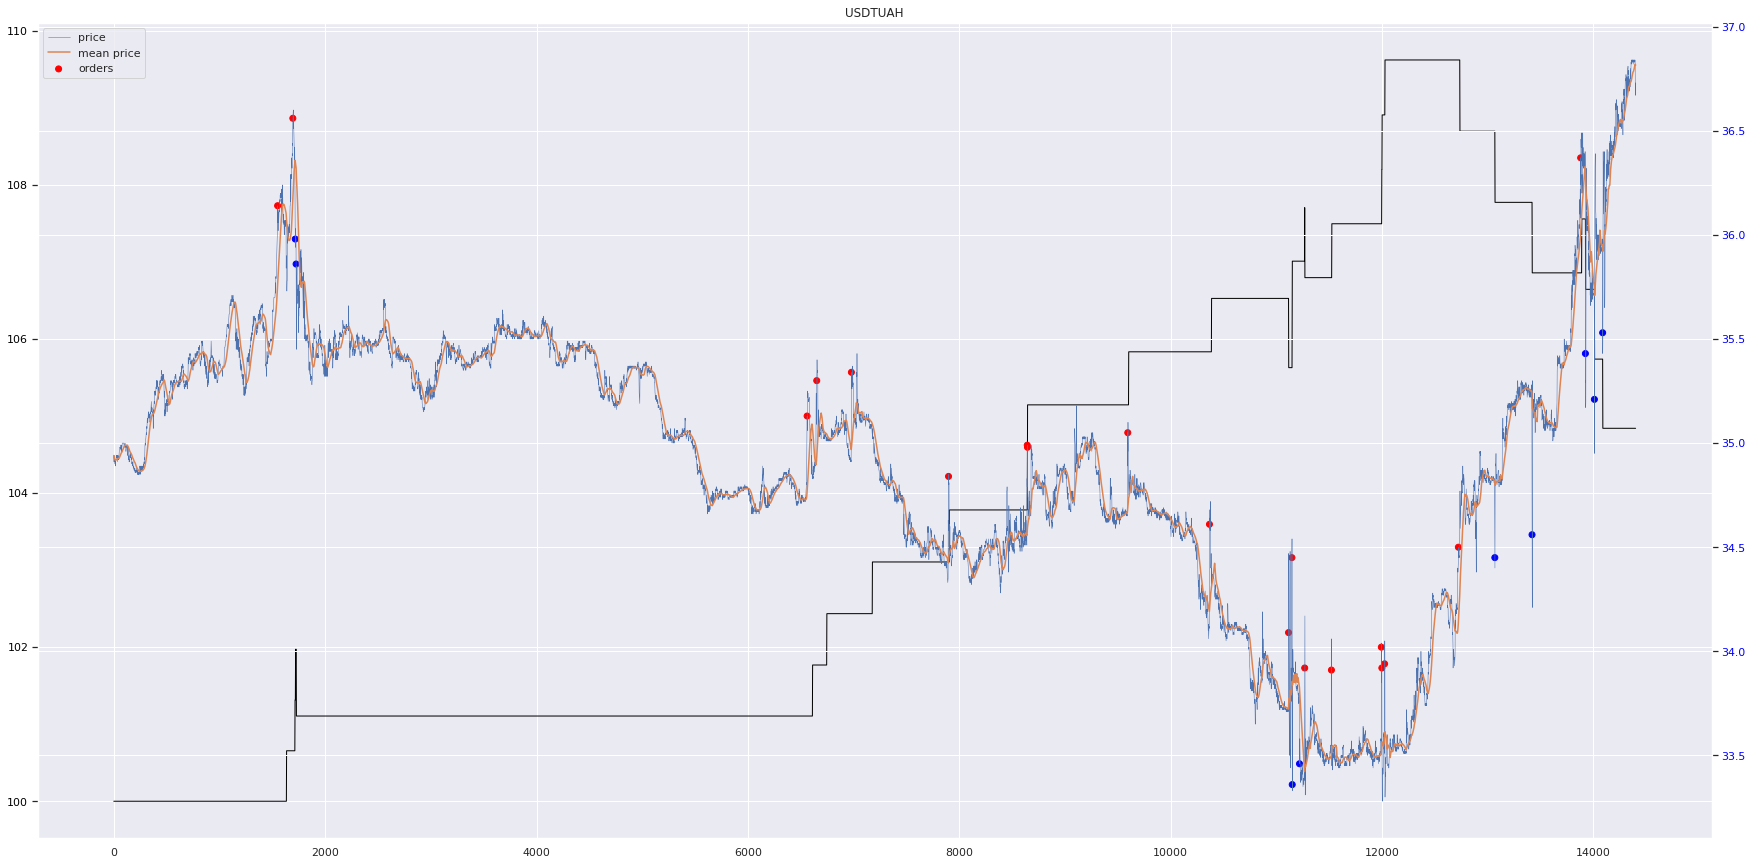

In [9]:
def get_candles(symbol, timeframe='3m'):
    dataset = pd.read_csv(f'{data_dir}/{symbol}/{timeframe}/{timeframe}.csv')
    dataset = dataset.to_numpy()[15:, 1:5] # drop first candles, take ohlc values
    return [Candle(*row) for row in dataset]

def plot(tr, title):
    fig, ax = plt.subplots(figsize=(30, 15))

    ax.plot([h['balance'] for h in tr.history], linewidth=1, color='black', label='balance')
    ax.tick_params(axis='y', labelcolor='black')

    ax2 = ax.twinx()
    ax2.plot([h['price'] for h in tr.history], linewidth=.5, label='price')
    ax2.plot([h['mean'] for h in tr.history], label='mean price')

    data = [(idx, h['price']) for idx, h in enumerate(tr.history) if 'order' in h]
    colors = ['red' if h['order'] == 'sell' else 'blue' for h in tr.history if 'order' in h]
    ax2.scatter(*zip(*data), color=colors, label='orders')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title(symbol)
    plt.legend()
    plt.show()

def score(candles, threshold, window):
    tr = Trader(threshold=threshold, window=window)
    tr.simulate(candles)
    print(f'{symbol:<10} threshold {threshold:<10} window {window:<10} {tr.history[-1]}')
    return tr.history[-1]['balance']


ncandles = 20 * 24 * 30
symbol = 'USDTUAH'

thresholds = [.01, .02]
windows = [20, 50, 100, 300]
candles = get_candles(symbol)
args = [(candles,) + params for params in product(thresholds, windows)]

with Pool(8) as p:
    scores = p.starmap(score, args)
    best = scores.index(max(scores))
    
candles, threshold, window = args[best]
tr = Trader(threshold, window)
tr.simulate(candles, start=-ncandles)
plot(tr, symbol)